In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from opt import generate_exclusion_list
from theano import tensor as T
sns.set_context('paper', font_scale=1.5)


/anaconda3/envs/compgen/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
proc_data = pd.read_pickle('data/exp2_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(
    proc_data, training_contexts=7, goal_chance=1/4.)
for e in excluded:
    proc_data = proc_data[proc_data.subj != e]
uids = list(set(proc_data.subj))
print len(uids)

100%|██████████| 148/148 [01:32<00:00,  1.68it/s]


N clusters = 2, Covarainace = diag
114


# Analyses

In [3]:
proc_data['Accuracy'] = proc_data['Reward'] / 10.0
proc_data['Training'] = proc_data.loc[:, 'Context'] < 8

Below, we plot the training data as a check that subjects learned the task

/anaconda3/envs/compgen/lib/python2.7/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


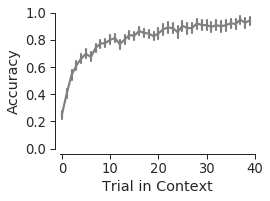

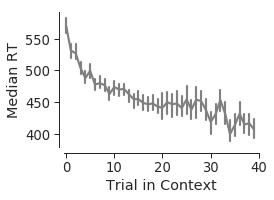

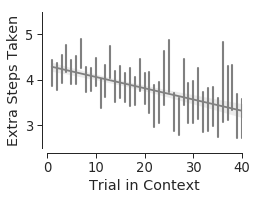

In [4]:
import scipy.stats
color = 'grey'
figsize = (3.5, 2.5)

with sns.axes_style('ticks'):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='Accuracy', 
                  data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                  ax=ax, markers=' ', color=color)
    lb, ub = ax.get_xlim()
    lb, ub = int(lb), int(ub)
    step = 10
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([0, 1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    plt.savefig('exp_4_goals_training_acc.png', dpi=300, bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='rt', data=proc_data[proc_data['Training']], 
                  estimator=np.median, ax=ax,  markers=' ', color=color)
    ax.set_ylabel('Median RT')
    ax.set_xlabel('Trial in Context')
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    sns.despine(offset=5)
    plt.savefig('exp_4_goals_training_rt.png', dpi=300, bbox_inches='tight')
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.regplot(x='Times Seen Context', y='Normalized Steps Taken',
                x_estimator=np.mean,
                data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                truncate=True,
                ax=ax, marker= ' ', color=color)
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([2.5, 5.5])
    ax.set_xlim([lb, ub+1])
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylabel('Extra Steps Taken')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    plt.savefig('exp_4_goals_training_steps.png', dpi=300, bbox_inches='tight')

In [5]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii
n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_train_acc:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_train_acc = pm.sample()
    
pm.stats.summary(trace_train_acc, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times]
/anaconda3/envs/compgen/lib/python2.7/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/anaconda3/envs/compgen/lib/python2.7/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.114746,0.003519,0.000124,0.107539,0.121305,750.806657,0.999166
beta_reps,0.770609,0.045149,0.001580,0.687365,0.862462,833.269792,1.000230


In [6]:
y = np.array(1. / X0['rt'].values)
y = (y - y.mean()) / y.std()

with pm.Model() as glm_rt:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat =  b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    # inference
    trace_rt = pm.sample()
    
pm.stats.summary(trace_rt, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.015758,0.000665,0.000020,0.014433,0.017025,854.090190,0.999347
beta_reps,0.082693,0.015341,0.000512,0.048858,0.108880,1070.694245,0.999120


In [7]:
y = np.array(X0['Normalized Steps Taken'].values)

with pm.Model() as glm_steps:
    
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=1.)  # have to use a more restrictive prior for the Poisson regression
    b_cr = pm.Normal('beta_reps',  mu=0., sd=1.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0.,   sd=1.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=1.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)

    # define linear model and exp link function
    theta = b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
            
    ## Define Poisson likelihood
    y_hat = pm.Poisson('y', mu=np.exp(theta), observed=y)
    
    # inference
    trace_steps = pm.sample()
    
pm.stats.summary(trace_steps, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_subj, sigma_sub, mu_subj, beta_reps, beta_times]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,-0.005922,0.000352,0.000017,-0.006636,-0.005267,363.842017,0.999573
beta_reps,-0.372501,0.009120,0.000290,-0.390901,-0.355374,910.929732,0.999043


Here, we plot the differences scores for the test conditions across time. Thes are the a priori comparisons identified by the generative models

/anaconda3/envs/compgen/lib/python2.7/site-packages/pandas/core/indexes/base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


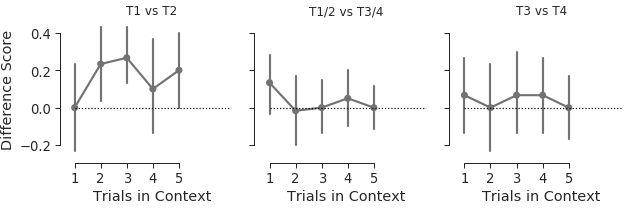

In [8]:
# plot the difference scores across time
df0 = df = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
                     (proc_data['Times Seen Context'] < 6)].copy()

score = list()

for uid in uids:
    subj_df = df0.loc[df0.subj == uid, :]

    if subj_df['Trial Number'].max() == df0['Trial Number'].max():

        grouped = subj_df.groupby(['Context', 'Times Seen Context']).mean()

        diff_1 = grouped.loc[8, 'Accuracy'] - grouped.loc[9, 'Accuracy']
        diff_2 = (grouped.loc[8, 'Accuracy'] + grouped.loc[9, 'Accuracy']) * 0.5 -\
                   (grouped.loc[10, 'Accuracy'] + grouped.loc[11, 'Accuracy']) * 0.5
        diff_3 = grouped.loc[10, 'Accuracy'] -  grouped.loc[11, 'Accuracy']

        n = len(diff_1)

        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_1,
                    'uniqueid': [uid] * n,
            }))
        
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1/2 vs T3/4'] * n,
                    'Difference Score': diff_2,
                    'uniqueid': [uid] * n,
            }))
        
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_3,
                    'uniqueid': [uid] * n,
            }))

score = pd.concat(score)      
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1 vs T2'],  
                  ax=axes[0], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1/2 vs T3/4'], 
                  ax=axes[1], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T3 vs T4'],  
                  ax=axes[2], color=[0.45, 0.45, 0.45])
    

    axes[0].set_xticklabels(range(1, 7))
    axes[0].set_ylabel('Difference Score')
    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    
    axes[0].set_title('T1 vs T2', fontdict={'size': 12})
    axes[1].set_title('T1/2 vs T3/4', fontdict={'size': 12})
    axes[2].set_title('T3 vs T4', fontdict={'size': 12})
    
    for ax in axes:
        ax.plot([0, 6], [0, 0], 'k:')
    
    plt.subplots_adjust(wspace=0.3)
    sns.despine(offset=5, trim=True)
    plt.tight_layout()


In [9]:
# run the bayesian GLM

X0 = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 8, dtype=int) - \
     (X0.Context.values == 9 )
    
x_2 = np.array((X0.Context.values == 8) | (X0.Context.values == 9), dtype=int) - \
     ((X0.Context.values == 10) | (X0.Context.values == 11))
    
x_3 = np.array(X0.Context.values == 10, dtype=int) - \
     (X0.Context.values == 11)
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_1 = pm.Normal('beta_ctxT1vs2',   mu=0., sd=100)
    b_2 = pm.Normal('beta_ctxT12vs34', mu=0., sd=100)
    b_3 = pm.Normal('beta_ctxT3vs4',   mu=0., sd=100)
    b_ti = pm.Normal('beta_times',     mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',      mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_1 * x_1 + b_2 * x_2 + b_3 * x_3 + \
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    glm_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times, beta_ctxT3vs4, beta_ctxT12vs34, beta_ctxT1vs2]
/anaconda3/envs/compgen/lib/python2.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
The number of effective samples is smaller than 25% for some parameters.


In [10]:
summary = pm.stats.summary(glm_trace, varnames=[
    'beta_ctxT1vs2', 'beta_ctxT12vs34', 'beta_ctxT3vs4', 'beta_times', 'beta_reps'
])
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_ctxT1vs2,0.139426,0.065874,0.000670,0.018372,0.274181,6856.220578,0.999874
beta_ctxT12vs34,0.059062,0.044745,0.000471,-0.024091,0.148729,8898.882903,0.999754
beta_ctxT3vs4,0.046989,0.060202,0.000686,-0.067875,0.165585,7840.614086,0.999837
beta_times,0.483092,0.033462,0.001075,0.423376,0.552957,948.947528,0.999761
beta_reps,0.922802,0.124279,0.001860,0.684771,1.163886,4113.662372,0.999778


In [11]:
# one sided tests
print 'P(1 > 2)     = %g' % np.mean(glm_trace['beta_ctxT1vs2'] < 0)
print 'P(1+2 > 3+4) = %g' % np.mean(glm_trace['beta_ctxT12vs34'] < 0)
print 'P(3 > 4)     = %g' % np.mean(glm_trace['beta_ctxT3vs4'] < 0)

P(1 > 2)     = 0.01775
P(1+2 > 3+4) = 0.09475
P(3 > 4)     = 0.22225


In [12]:
# follow up comparisons
hpd = pm.stats.hpd(glm_trace['beta_ctxT1vs2'] + glm_trace['beta_ctxT12vs34'])
mu = np.mean(glm_trace['beta_ctxT1vs2'] + glm_trace['beta_ctxT12vs34'])
print "P(1 > 3+4) = %g, HPD = (%g, %g)" % (mu, hpd[0], hpd[1])


hpd = pm.stats.hpd(glm_trace['beta_ctxT12vs34'] - glm_trace['beta_ctxT1vs2'])
mu = np.mean(glm_trace['beta_ctxT12vs34'] - glm_trace['beta_ctxT1vs2'])
print "P(2 > 3+4) = %g, HPD = (%g, %g)" % (mu, hpd[0], hpd[1])

P(1 > 3+4) = 0.198488, HPD = (0.0456362, 0.356778)
P(2 > 3+4) = -0.0803643, HPD = (-0.235322, 0.0768455)


In [13]:
# Compare model to a reduced model with out the contrasts
with pm.Model() as glm_reduced:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub    = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub     = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_reduced = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times]
The number of effective samples is smaller than 25% for some parameters.


In [14]:
df_comp_LOO = pm.compare({glm:glm_trace, glm_reduced:trace_reduced}, ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Flat',  'Reduced'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
Reduced,3155.35,119.03,0,0.52,60.64,0,0
Flat,3155.79,124.02,0.44,0.48,60.9,6.08,0


In [15]:
df_comp_WAIC = pm.compare({glm:glm_trace, glm_reduced:trace_reduced},ic='WAIC')
df_comp_WAIC.index =  [
    {ii: name for ii, name in enumerate(['Full',  'Reduced', ])}[idx] 
    for idx in df_comp_WAIC.index ]

df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
Reduced,3155.01,118.86,0,0.52,60.64,0,0
Full,3155.43,123.83,0.42,0.48,60.9,6.08,0


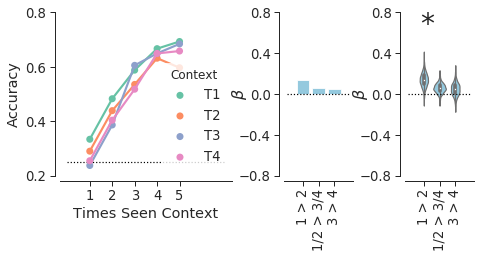

In [16]:
betas = pd.DataFrame({
        'T1vsT2': glm_trace['beta_ctxT1vs2'],
        'T1/2vsT3/4': glm_trace['beta_ctxT12vs34'],
        'T3vsT4':   glm_trace['beta_ctxT3vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(7.43, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1, 1], wspace=0.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]))
    
    # show time series data as well
    df = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()
    
    ax=axes[0]
    sns.pointplot(x='Times Seen Context', y='Accuracy', hue='Context', #units='uniqueid',
                  estimator=np.mean, marker='.',
                        data=df[df['Times Seen Context'] < 6], palette='Set2', ax=ax, ci=None)

    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')

    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticklabels(range(1, 11))
    ax.set_ylabel('Accuracy')
    ax.plot([-1, 6], [1./4, 1./4], 'k:')
    ax.set_ylim([0.2, 0.8])
    sns.despine(offset=5)

    ax = axes[1]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=axes[1],
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[2]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})
    
    for ii in range(1, 3):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.8, -.4, 0, 0.4, 0.8])
        axes[ii].set_xlabel('')

    # only the first comparison is significant
    ax.annotate("*", xy=(-0.25, 0.6), size=28)

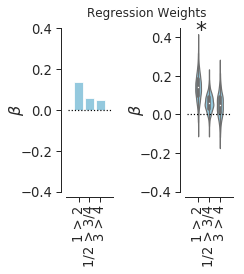

In [17]:
summary = pm.stats.summary(glm_trace, varnames=[
    'beta_ctxT1vs2', 'beta_ctxT12vs34', 'beta_ctxT3vs4', 'beta_times', 'beta_reps'
])

from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(3, 3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=1.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]))    

    ax = axes[0]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=ax,
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-6, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[1]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-6, fontdict={'size': 16, 'weight': 'bold'})
    
    sns.despine(offset=5)
    
    for ii in range(0, 2):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.4, -.2, 0, 0.2, 0.4])
        axes[ii].set_xlabel('')

    for ii, label in enumerate(['beta_ctxT1vs2', 'beta_ctxT12vs34', 'beta_ctxT3vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.27, 0.4), size=22)
            
    plt.suptitle('Regression Weights')
    
#     plt.savefig('exp2_fig1_data.png', dpi=300, bbox_inches='tight')

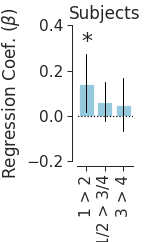

In [18]:

sns.set_context('paper', font_scale=1.75)


betas = pd.DataFrame({
        'T1vsT2': glm_trace['beta_ctxT1vs2'],
        'T1/2vsT3/4': glm_trace['beta_ctxT12vs34'],
        'T3vsT4':   glm_trace['beta_ctxT3vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(1, 1, figsize=(1.0, 2.5))   

    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=ax,
#                  estimator=np.median, 
                color='skyblue', ci=None,
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    summary = pm.summary(glm_trace)
    for ii, b in enumerate('beta_ctxT1vs2 beta_ctxT12vs34 beta_ctxT3vs4'.split()):
        ylb = summary.loc[b, 'hpd_2.5']
        yub = summary.loc[b, 'hpd_97.5']
        ax.plot([ii,ii], [ylb, yub], 'k', linewidth=1)
        
#     for ii, b in enumerate('beta_ctxT1vs2 beta_ctxT12vs34 beta_ctxT3vs4'.split()):
#         sd = summary.loc[b, 'sd']
#         mu = summary.loc[b, 'mean']
#         ax.plot([ii,ii], [mu-sd, mu+sd], 'k', linewidth=3)
    
    ax.set_ylabel(r'Regression Coef. ($\beta$)')#, labelpad=)#, fontdict={'size': 16})#, 'weight': 'bold'})

    
    sns.despine(offset=5)

    plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_xlabel('')
    ax.set_ylim([-0.2, 0.4])
    ax.set_xlim([-0.5, 2.5])

    for ii, label in enumerate(['beta_ctxT1vs2', 'beta_ctxT12vs34', 'beta_ctxT3vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.27, 0.3), size=22)
    plt.title('Subjects',)
    plt.savefig('exp_4_goals_behav.png', dpi=300, bbox_inches='tight')
    

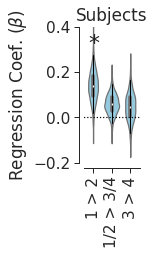

In [19]:

sns.set_context('paper', font_scale=1.75)


betas = pd.DataFrame({
        'T1vsT2': glm_trace['beta_ctxT1vs2'],
        'T1/2vsT3/4': glm_trace['beta_ctxT12vs34'],
        'T3vsT4':   glm_trace['beta_ctxT3vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(1, 1, figsize=(1.0, 2.5))   

    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax,
#                  estimator=np.median, 
                color='skyblue', ci=None,
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    summary = pm.summary(glm_trace)
    for ii, b in enumerate('beta_ctxT1vs2 beta_ctxT12vs34 beta_ctxT3vs4'.split()):
        ylb = summary.loc[b, 'hpd_2.5']
        yub = summary.loc[b, 'hpd_97.5']
        ax.plot([ii,ii], [ylb, yub], 'k', linewidth=1)
        
#     for ii, b in enumerate('beta_ctxT1vs2 beta_ctxT12vs34 beta_ctxT3vs4'.split()):
#         sd = summary.loc[b, 'sd']
#         mu = summary.loc[b, 'mean']
#         ax.plot([ii,ii], [mu-sd, mu+sd], 'k', linewidth=3)
    
    ax.set_ylabel(r'Regression Coef. ($\beta$)')#, labelpad=)#, fontdict={'size': 16})#, 'weight': 'bold'})

    
    sns.despine(offset=5)

    plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_xlabel('')
    ax.set_ylim([-0.2, 0.4])
    ax.set_xlim([-0.5, 2.5])

    for ii, label in enumerate(['beta_ctxT1vs2', 'beta_ctxT12vs34', 'beta_ctxT3vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.27, 0.3), size=22)
    plt.title('Subjects',)
#     plt.savefig('exp_4_goals_behav.png', dpi=300, bbox_inches='tight')
    

In [20]:
pm.summary(glm_trace, varnames=['beta_ctxT1vs2', 'beta_ctxT12vs34', 
                                'beta_ctxT3vs4', 'beta_times', 'beta_reps'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_ctxT1vs2,0.139426,0.065874,0.000670,0.018372,0.274181,6856.220578,0.999874
beta_ctxT12vs34,0.059062,0.044745,0.000471,-0.024091,0.148729,8898.882903,0.999754
beta_ctxT3vs4,0.046989,0.060202,0.000686,-0.067875,0.165585,7840.614086,0.999837
beta_times,0.483092,0.033462,0.001075,0.423376,0.552957,948.947528,0.999761
beta_reps,0.922802,0.124279,0.001860,0.684771,1.163886,4113.662372,0.999778


/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning

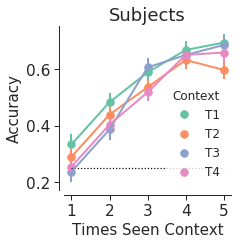

In [21]:
#within subject errorbars (standard error)

cc = sns.color_palette('Set2')
def plot_test_context(ctx, ax, color, label):
    ctx = df.loc[(df['Times Seen Context'] < 6) & (df['Context'] == ctx), 'Accuracy'
                ].values.reshape(len(uids), -1)
    
    ctx_std_err = np.std(ctx - np.tile(ctx.mean(axis=1), (5, 1)).T - 
                         ctx.mean(), axis=0) / np.sqrt(len(uids))

    plt.plot(range(1, 6), ctx.mean(axis=0), color=color, label=label,
                linewidth=0, marker='.', markersize=15)
    (_, caps, _) = plt.errorbar(range(1, 6), ctx.mean(axis=0), ctx_std_err, color=color,
                linewidth=2)
    
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(3,3))
    plot_test_context(8, ax, cc[0], 'T1')
    plot_test_context(9, ax, cc[1], 'T2')
    plot_test_context(10, ax, cc[2], 'T3')
    plot_test_context(11, ax, cc[3], 'T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1, fontsize=12)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticks(range(1, 6))
    ax.set_xlabel('Times Seen Context', fontsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.plot([1, 5], [1./4, 1./4], 'k:')
#     ax.set_ylim([0.2, 0.8])
    plt.title('Subjects', fontsize=18, fontname='Helvetica')
    sns.despine(offset=5)
    
    
# plt.savefig('exp2_fig1a_data.png', dpi=300, bbox_inches='tight')

In [22]:
1 - np.mean(betas['T1vsT2'] > 0)

0.017750000000000044

# First Trial analysis


In [23]:
# Do a "Bayesian Analysis" to follow up analyses on the accuracy in the first context
# Generate the data
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)
               & ~proc_data['Training'] ]

y_t1 = d0.loc[d0.Context == 8, 'Accuracy'].values 
y_t2 = d0.loc[d0.Context == 9, 'Accuracy'].values 
y_t3 = d0.loc[d0.Context == 10, 'Accuracy'].values 
y_t4 = d0.loc[d0.Context == 11, 'Accuracy'].values 


with pm.Model() as binom_model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    # define the likelihood
    y_t1 = pm.Bernoulli('y_t1', p=theta1, observed=y_t1)
    y_t2 = pm.Bernoulli('y_t2', p=theta2, observed=y_t2)
    y_t3 = pm.Bernoulli('y_t3', p=theta3, observed=y_t3)
    y_t4 = pm.Bernoulli('y_t4', p=theta4, observed=y_t4)
    
    # Generate a MCMC chain
    trace_bin = pm.sample(10000, pm.Metropolis())  # Use Metropolis sampling

pm.stats.summary(trace_bin)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta4]
>Metropolis: [theta3]
>Metropolis: [theta2]
>Metropolis: [theta1]
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.332628,0.043226,0.000757,0.248913,0.416207,3558.012683,1.000563
theta2,0.289438,0.042229,0.000735,0.205234,0.369993,3523.194801,0.999968
theta3,0.237826,0.039219,0.000674,0.163346,0.312631,3381.838649,0.999987
theta4,0.253007,0.040139,0.000772,0.174619,0.329713,3164.831692,1.000098


In [24]:
print 1 - np.mean(trace_bin['theta1'] > 0.25)
print 1 - np.mean(trace_bin['theta2'] > 0.25)
print 1 - np.mean(trace_bin['theta3'] > 0.25)
print 1 - np.mean(trace_bin['theta4'] > 0.25)

0.02234999999999998
0.17305000000000004
0.6283000000000001
0.4937


# Frequency with which each goal was chosen in novel contexts

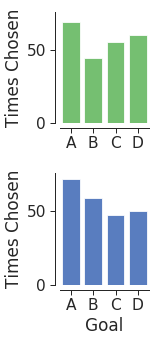

In [25]:
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(2, 1, sharey=True, figsize=(2.5, 5))

    d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==8) | (proc_data['Context']==9))]

    d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==11) | (proc_data['Context']==10)) ]

    cc = sns.color_palette('muted')
    sns.countplot(d0['Chosen Goal'], ax=axes[1], order='A B C D'.split(), color=cc[0])
    sns.countplot(d1['Chosen Goal'], ax=axes[0], order='A B C D'.split(), color=cc[2])
    
    for ii in [0, 1]:
        ax = axes[ii]
        ax.set_ylabel('Times Chosen')
    
    ax = axes[1]
    ax.set_xlabel('Goal')

    ax = axes[0]
    ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()


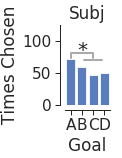

In [49]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))
    d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==8) | (proc_data['Context']==9))]

    cc = sns.color_palette('muted')
    sns.countplot(d0['Chosen Goal'], ax=ax, order='A B C D'.split(), color=cc[0])

    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Subj')
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # b/c the statistics below are signficant, plot the error bars
    # Add significance bars -- I've done this by hand
    y_max = 70
    y_min = 0
    ax.text(1.0, y_max+15, "*", size=20, horizontalalignment='center', verticalalignment='center')
    ax.annotate("", xy=(0, y_max), xycoords='data', xytext=(2, y_max), textcoords='data', 
                arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.3"))
    ax.annotate("", xy=(1, y_max), xycoords='data', xytext=(3.0, y_max), textcoords='data', 
                arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.0"))
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])
    ax.set_title(r'Subj')

    plt.tight_layout()
    plt.savefig('exp_4_goals_behav_b.png', dpi=300, bbox_inches='tight')
    

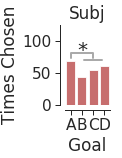

In [27]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))
    d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
       & (proc_data['Times Seen Context']==1) & 
               ((proc_data['Context']==11) | (proc_data['Context']==10)) ]

    cc = sns.color_palette('muted')
    sns.countplot(d1['Chosen Goal'], ax=ax, order='A B C D'.split(), color=cc[3])

    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Subj')
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # b/c the statistics below are signficant, plot the error bars
    # Add significance bars -- I've done this by hand
    y_max = 70
    y_min = 0
    ax.text(1.0, y_max+15, "*", size=20, horizontalalignment='center', verticalalignment='center')
    ax.annotate("", xy=(0, y_max), xycoords='data', xytext=(2, y_max), textcoords='data', 
                arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.3"))
    ax.annotate("", xy=(1, y_max), xycoords='data', xytext=(3.0, y_max), textcoords='data', 
                arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.0"))
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])
    ax.set_title(r'Subj')

    plt.tight_layout()
    plt.savefig('exp_4_goals_behav_c.png', dpi=300, bbox_inches='tight')
    

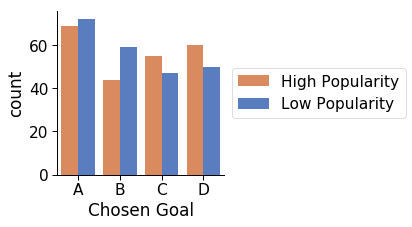

In [28]:
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
               & (proc_data['Training']==False) 
           & (proc_data['Times Seen Context']==1)].copy()
d0['Counts'] = [1] * len(d0)

d0['Mapping'] = ['High Popularity'] * len(d0)
d0.loc[(d0['Context'] == 8) | (d0['Context'] == 9), 'Mapping'] = 'Low Popularity'

fig, ax = plt.subplots(figsize=(3, 3))
cc = [sns.color_palette('muted')[1], sns.color_palette('muted')[0]]
sns.countplot(data=d0, x='Chosen Goal', order='A B C D'.split(), hue='Mapping', 
             palette=cc)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()

Use Bayesian Model Comparisions to look at whether the hand influenced the goal choice probability. 

In [29]:
# d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
#            & (proc_data['Times Seen Context']==1) & ((proc_data['Context']>=8))]

# # Generate the data
# y_A = np.array(d0['Chosen Goal'].values == 'A') 
# y_B = np.array(d0['Chosen Goal'].values == 'B') 
# y_C = np.array(d0['Chosen Goal'].values == 'C') 
# y_D = np.array(d0['Chosen Goal'].values == 'D') 

d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) & 
       ((proc_data['Context'] == 8) | (proc_data['Context'] == 9))
      ]
d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) & 
       ((proc_data['Context'] == 10) | (proc_data['Context'] == 11))
      ]

y_A_m0 = np.array(d0['Chosen Goal'].values == 'A') 
y_B_m0 = np.array(d0['Chosen Goal'].values == 'B') 
y_C_m0 = np.array(d0['Chosen Goal'].values == 'C') 
y_D_m0 = np.array(d0['Chosen Goal'].values == 'D') 

y_A_m1 = np.array(d1['Chosen Goal'].values == 'A') 
y_B_m1 = np.array(d1['Chosen Goal'].values == 'B') 
y_C_m1 = np.array(d1['Chosen Goal'].values == 'C') 
y_D_m1 = np.array(d1['Chosen Goal'].values == 'D') 


with pm.Model() as model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    
    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=theta1, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=theta2, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=theta3, observed=y_C_m0)
    y_D_m0_hat = pm.Bernoulli('y_D0', p=theta4, observed=y_D_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=theta1, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=theta2, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=theta3, observed=y_C_m1)
    y_D_m1_hat = pm.Bernoulli('y_D1', p=theta4, observed=y_D_m1)
    
    # Generate a MCMC chain
    trace = pm.sample(2000) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta4, theta3, theta2, theta1]


In [30]:
print pm.summary(trace)

            mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
theta1  0.309256  0.021602  0.000322  0.266960  0.351552  5042.175555   
theta2  0.225758  0.019547  0.000241  0.188777  0.263700  6368.829759   
theta3  0.223795  0.018954  0.000244  0.185803  0.259929  5369.710401   
theta4  0.241496  0.020222  0.000293  0.203716  0.281098  5707.984628   

            Rhat  
theta1  0.999950  
theta2  0.999828  
theta3  0.999811  
theta4  0.999959  


In [31]:
with pm.Model() as model_null:
    # define the prior
    theta = pm.Beta('theta1', 10e-5, 10e-5)  # prior

    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=theta, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=theta, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=theta, observed=y_C_m0)
    y_D_m0_hat = pm.Bernoulli('y_D0', p=theta, observed=y_D_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=theta, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=theta, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=theta, observed=y_C_m1)
    y_D_m1_hat = pm.Bernoulli('y_D1', p=theta, observed=y_D_m1)
    
    # Generate a MCMC chain
    trace_null = pm.sample(2000)  # Use Metropolis sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta1]


In [32]:


with pm.Model() as model_goal_full:
    # define the prior
    thetaA0 = pm.Beta('thetaA0', 10e-5, 10e-5)  # prior
    thetaB0 = pm.Beta('thetaB0', 10e-5, 10e-5)  # prior
    thetaC0 = pm.Beta('thetaC0', 10e-5, 10e-5)  # prior
    thetaD0 = pm.Beta('thetaD0', 10e-5, 10e-5)  # prior
    
    thetaA1 = pm.Beta('thetaA1', 10e-5, 10e-5)  # prior
    thetaB1 = pm.Beta('thetaB1', 10e-5, 10e-5)  # prior
    thetaC1 = pm.Beta('thetaC1', 10e-5, 10e-5)  # prior
    thetaD1 = pm.Beta('thetaD1', 10e-5, 10e-5)  # prior
    
    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=thetaA0, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=thetaB0, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=thetaC0, observed=y_C_m0)
    y_D_m0_hat = pm.Bernoulli('y_D0', p=thetaD0, observed=y_D_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=thetaA1, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=thetaB1, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=thetaC1, observed=y_C_m1)
    y_D_m1_hat = pm.Bernoulli('y_D1', p=thetaD1, observed=y_D_m1)
    
    # Generate a MCMC chain
    trace_full = pm.sample(2000)  # Use Metropolis sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [thetaD1, thetaC1, thetaB1, thetaA1, thetaD0, thetaC0, thetaB0, thetaA0]


In [33]:
model_dict = {model: trace, model_null: trace_null, model_goal_full: trace_full}
df_comp_LOO = pm.compare(model_dict, ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Independent', 'Flat', 'Joint'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
Independent,2047.85,3.97,0,0.58,41.11,0,0
Joint,2051.33,8.18,3.48,0.15,41.44,4.53,0
Flat,2053.29,0.95,5.44,0.27,40.75,6.9,0


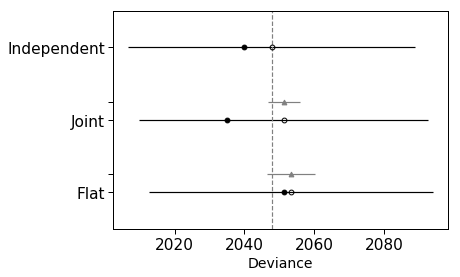

In [34]:
pm.compareplot(df_comp_LOO)

### comparisons of interest

0.0024999999999999467


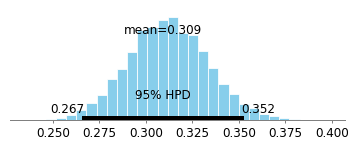

In [35]:
# P(A) > 0.25
print 1-np.mean(trace['theta1']>0.25)
pm.plot_posterior(trace['theta1'])

0.9995


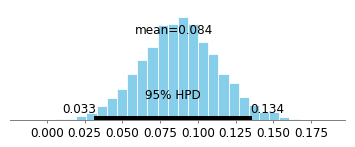

In [36]:
# P(A) > P(B, C)
print np.mean(trace['theta1'] > 1./2*(trace['theta2'] + trace['theta3'] ))
pm.plot_posterior(trace['theta1'] - 1./2*(trace['theta2'] + trace['theta3'] ))

In [37]:
np.mean(trace['theta1'] - 1./2*(trace['theta2'] + trace['theta3']))

0.08447973698009599

0.9995


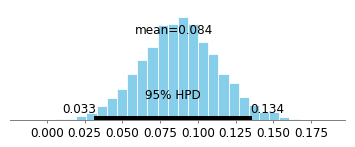

In [38]:
# P(A) > P(B or C)
print np.mean(trace['theta1'] > 1./2*(trace['theta2'] + trace['theta3']))
pm.plot_posterior(trace['theta1'] - 1./2*(trace['theta2'] + trace['theta3']))

In [39]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.309256,0.021602,0.000322,0.266960,0.351552,5042.175555,0.999950
theta2,0.225758,0.019547,0.000241,0.188777,0.263700,6368.829759,0.999828
theta3,0.223795,0.018954,0.000244,0.185803,0.259929,5369.710401,0.999811
theta4,0.241496,0.020222,0.000293,0.203716,0.281098,5707.984628,0.999959


In [40]:
pm.stats.summary(trace_full)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
thetaA0,0.315462,0.031033,0.000388,0.254472,0.375552,4681.737397,1.000261
thetaB0,0.258395,0.029388,0.000423,0.204818,0.318611,4690.654916,1.001110
thetaC0,0.206404,0.027271,0.000458,0.155280,0.260383,3778.749594,1.000133
thetaD0,0.219006,0.027386,0.000367,0.164043,0.271294,5580.421161,0.999884
thetaA1,0.303229,0.030060,0.000414,0.242714,0.360890,5655.933934,1.000581
thetaB1,0.192685,0.026471,0.000325,0.141698,0.244923,5536.771008,1.000157
thetaC1,0.241729,0.028385,0.000390,0.184172,0.294607,5109.422841,0.999764
thetaD1,0.263929,0.028840,0.000389,0.207592,0.321844,5266.623993,0.999866


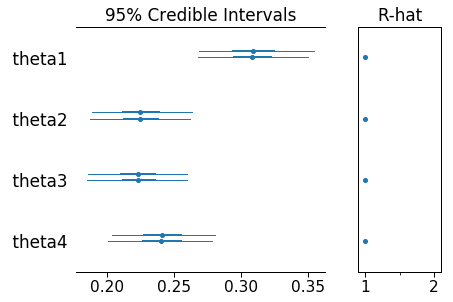

In [41]:
pm.forestplot(trace)

0.99575


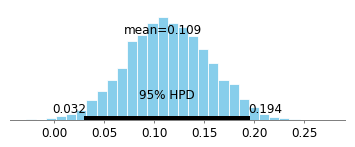

In [42]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA0'] > trace_full['thetaC0'])
pm.plot_posterior(trace_full['thetaA0'] - trace_full['thetaC0'])

0.928


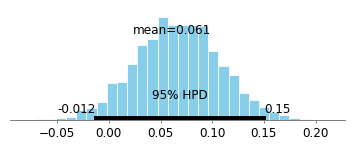

In [43]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA1'] > trace_full['thetaC1'])
pm.plot_posterior(trace_full['thetaA1'] - trace_full['thetaC1'])

0.08602176170330413
0.99375


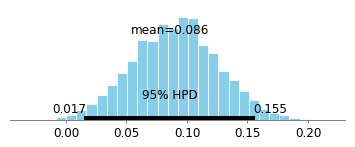

In [44]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA1'] -
              0.5*(trace_full['thetaC1'] + trace_full['thetaB1']))
print np.mean(trace_full['thetaA1'] > 
              0.5*(trace_full['thetaC1'] + trace_full['thetaB1']))
pm.plot_posterior(trace_full['thetaA1'] - 
                  0.5*(trace_full['thetaC1'] + trace_full['thetaB1']))

0.08306218928158461
0.9865


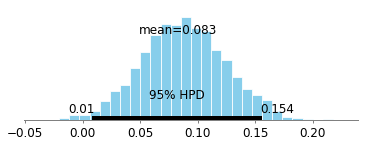

In [45]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA0'] -
              0.5*(trace_full['thetaC0'] + trace_full['thetaB0']))
print np.mean(trace_full['thetaA0'] > 
              0.5*(trace_full['thetaC0'] + trace_full['thetaB0']))
pm.plot_posterior(trace_full['thetaA0'] - 
                  0.5*(trace_full['thetaC0'] + trace_full['thetaB0']))

0.371


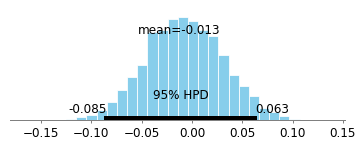

In [46]:
# full model
# P(C | map1) > P(D | map1)
print np.mean(trace_full['thetaC0'] > trace_full['thetaD0'])
pm.plot_posterior(trace_full['thetaC0'] - trace_full['thetaD0'])

0.1825


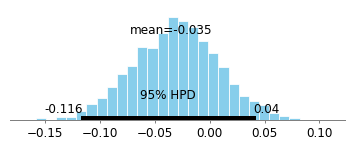

In [47]:
# full model
# P(C | map1) > P(D | map1)
print np.mean(trace_full['thetaC0'] > trace_full['thetaC1'])
pm.plot_posterior(trace_full['thetaC0'] - trace_full['thetaC1'])

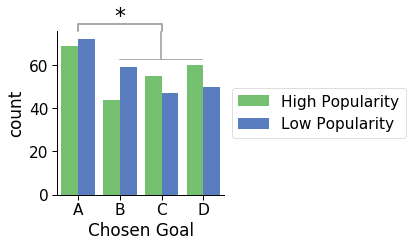

In [48]:
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
               & (proc_data['Training']==False) 
           & (proc_data['Times Seen Context']==1)].copy()
d0['Counts'] = [1] * len(d0)

d0['Mapping'] = ['High Popularity'] * len(d0)
d0.loc[(d0['Context'] == 8) | (d0['Context'] == 9), 'Mapping'] = 'Low Popularity'

fig, ax = plt.subplots(figsize=(3, 3))
cc = [sns.color_palette('muted')[2], sns.color_palette('muted')[0]]
sns.countplot(data=d0, x='Chosen Goal', order='A B C D'.split(), hue='Mapping', 
             palette=cc)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Add significance bars -- I've done this by hand
y_max = 75
y_min = 0

ax.text(1.0, y_max + abs(y_max - y_min)*0.1, "*", size=22,
   horizontalalignment='center', verticalalignment='center')

ax.annotate("", xy=(0, y_max), xycoords='data', xytext=(2, y_max), textcoords='data', 
            arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                       connectionstyle="bar,fraction=0.1"))
ax.arrow(1.97, y_max+1, 0,  -13, width=0.03, head_width=2, head_length=0.0,  color='#aaaaaa')

sns.despine()